In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
from numpy.linalg import eig   
from sklearn import metrics 
import random
from sklearn.decomposition import PCA
import sys

In [2]:
# Read input data
inputData = pd.read_csv("Dataset.txt", sep='\t', lineterminator='\n', header=None)
data = np.array(inputData.iloc[:,2:])
groundTruthClusters = np.array(inputData[inputData.columns[1:2]])

In [3]:
# Assign Parameters
Mu = [[0,0],[1,1]]
sigmas = [[[1,1],[1,1]],[[2,2],[2,2]]]
pi = [0.5,0.5]
maxIter = 100

In [4]:
#######################################################################
# Expectation-Maximization function
#######################################################################
def GMM(data,mu,sigma,phi,iterations):
    
    # Copy the parameters to new variables
    Phi = np.copy(phi)
    Mu = np.copy(mu)
    Sigma = np.copy(sigma)
    Sigma = np.nan_to_num(Sigma)
    prob_x = np.zeros((len(Mu),len(data)))
    num_clusters = len(Mu)
    num_data = len(data)
    
    ############ Expectation step ############
    
    # Use the probability density function to calculate the probability of data points being in different clusters
    for i in range(num_clusters):
        prob_x[i] =  Phi[i]*multivariate_normal.pdf(data, mean=Mu[i], cov=Sigma[i],allow_singular = True)
    prob_x = prob_x/np.sum(prob_x,axis=0)
    class_vector = np.argmax(prob_x,axis=0)
    
    ############ Maximization step ############
    
    # Calculate maximum  log-likelihood and recompute the parameters until they converge
    for i in range(iterations):
        Mu = np.zeros(Mu.shape)
        Sigma = np.zeros(Sigma.shape)
        for i in range(num_clusters):
            Phi[i] = np.mean(prob_x[i])
            Mu[i] = np.sum(prob_x[i][:,None] * data , axis=0)/np.sum(prob_x[i])
            diff = (data-Mu[i])
            for j in range(num_data):
                diff_T = np.transpose(diff[j])
                diff_T_r = diff_T.reshape(len(diff[j]),1)
                diff_sq = np.multiply(diff_T_r,diff[j])
                Sigma[i] += np.dot(prob_x[i][j],diff_sq)
            Sigma[i] = np.dot(1/np.sum(prob_x[i]),Sigma[i]) 
        for i in range(num_clusters):
            prob_x[i] =  Phi[i]*multivariate_normal.pdf(data, mean=Mu[i], cov=Sigma[i],allow_singular = True)
        prob_x = prob_x/np.sum(prob_x,axis=0)
        class_vector = np.argmax(prob_x,axis=0)
    return Mu,class_vector

In [5]:
MuFinal,clusterLabels = GMM(data,Mu,sigmas,pi,maxIter)

In [6]:
#######################################################################
# Function to compute and plot PCA
#######################################################################
def plotPCA(data,labels,MuFinal):
    
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    lb=list(set(labels.astype(int)))
    
    colors=['red','green','blue','purple','black','orange','pink','magenta','brown','yellow']
    
    for i in range(len(MuFinal)):
        x,y = data[labels.ravel()==i][:, 0].flatten(), data[labels.ravel()==i][:, 1].flatten()
        plt.scatter(x,y, marker= 'o' ,color=colors[i], label=lb[i])
    
    plt.legend()
    plt.title("GMM plot")
    plt.show()

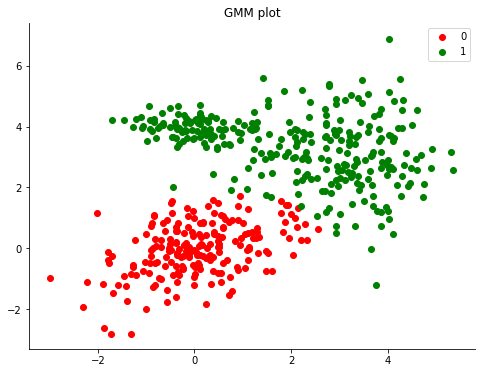

In [7]:
plotPCA(data,clusterLabels,MuFinal)

In [8]:
#######################################################################
# Function to compute Jaccard coefficient and Rand index
#######################################################################
def metric(data,groundTruthClusters,output):
    m11=0
    m10=0
    m01=0
    m00=0
    
    for i in range(0,len(data)):
        for j in range(1,len(data)):
            if((groundTruthClusters)[i] == (groundTruthClusters)[j] and output[i] == output[j]):
                m11=m11+1
            elif((groundTruthClusters)[i] == (groundTruthClusters)[j] and not (output[i] == output[j])):
                m10=m10+1
            elif(not((groundTruthClusters)[i] == (groundTruthClusters)[j]) and output[i] == output[j]):
                m01=m01+1
            elif(not((groundTruthClusters)[i] == (groundTruthClusters)[j]) and not(output[i] == output[j])):
                m00=m00+1


    jacard_coeff=float(m11)/float((m11+m01+m10))
    print("Jaccard Coefficient: ", jacard_coeff)
    rand_index=float((m11+m00))/float((m11+m00+m10+m01))
    print("Rand Index: ", rand_index)

In [9]:
# Compute Jaccard coefficient and Rand index
metric(data,groundTruthClusters,clusterLabels)

Jaccard Coefficient:  0.630362961622013
Rand Index:  0.8035871743486974
